# Install package

# Calculate communication

In [1]:
library(community)
library(ggplot2)
library(gridExtra)
library(grid)
library(ComplexHeatmap)
library(dendsort)
library(igraph)
require(circlize)
library(R.utils)
library(data.table)
library(Seurat)
library(nichenetr)

ComplexHeatmap version 2.15.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))



Attache Paket: ‘igraph’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    decompose, spectrum


Das folgende Objekt ist maskiert ‘package:base’:

    union


Lade nötiges Paket: circlize

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https:/

In [2]:
input_dir <- "../../../results//data_preprocessing/Smillie/batch_corrected/"
output_dir <- "../../../results//data_preprocessing/Smillie/community_analysis/"

In [3]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/fsalcher/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=de_AT.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_AT.UTF-8        LC_COLLATE=de_AT.UTF-8    
 [5] LC_MONETARY=de_AT.UTF-8    LC_MESSAGES=de_AT.UTF-8   
 [7] LC_PAPER=de_AT.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_AT.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] nichenetr_2.0.0       SeuratObject_4.1.3    Seurat_4.3.0.1       
 [4] data.table_1.14.8     R.utils_2.12.2        R.oo_1.25.0          
 [7] R.methodsS3_1.8.2     circlize_0.4.15       igraph_1.5.0.1       
[10] dendsort_0.3.4        ComplexHeatmap_2.15.2 gridExtra_2.3        
[13] ggplot2_

## Load data

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [4]:
data("LR_database")
print(str(LR_database))

'data.frame':	6941 obs. of  26 variables:
 $ Pair.Name            : chr  "A2M_LRP1" "ACTR2_ADRB2" "ACTR2_LDLR" "ACTR2_LRP2" ...
 $ Ligand               : chr  "A2M" "ACTR2" "ACTR2" "ACTR2" ...
 $ Ligand.Name          : chr  "alpha-2-macroglobulin" "actin related protein 2" "actin related protein 2" "actin related protein 2" ...
 $ Receptor             : chr  "LRP1" "ADRB2" "LDLR" "LRP2" ...
 $ Receptor.Name        : chr  "LDL receptor related protein 1" "adrenoceptor beta 2" "low density lipoprotein receptor" "LDL receptor related protein 2" ...
 $ complex_pair         : chr  NA NA NA NA ...
 $ partner_a            : chr  "P01023" "P61160" "P61160" "P61160" ...
 $ partner_b            : chr  "Q07954" "P07550" "P01130" "P98164" ...
 $ source               : chr  "P01023" "P61160" "P61160" "P61160" ...
 $ target               : chr  "Q07954" "P07550" "P01130" "P98164" ...
 $ source_genesymbol    : chr  "A2M" "ACTR2" "ACTR2" "ACTR2" ...
 $ target_genesymbol    : chr  "LRP1" "ADRB2" "LDLR"

In [8]:
# # load counts
print("load counts")
counts <- fread(paste0(input_dir, "counts_corr.csv.gz"), header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	13861 obs. of  93593 variables:
 $ N10.EpiA.AACATTGAAAGTAG    : num  0 0 0 0 0 ...
 $ N10.EpiA.AACCCAGACGTAAC    : num  0 0 0 0 1.49 ...
 $ N10.EpiA.AATCTCACCGCATA    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.ACAATAACCGCTAA    : num  0 0 0 0 0.533 ...
 $ N10.EpiA.ACAATTGATGCAGT    : num  0 0 0 0 0.396 ...
 $ N10.EpiA.ACAGTGTGTTGGTG    : num  0 0 0 0 0 ...
 $ N10.EpiA.ACCGTGCTACTCAG    : num  0 1.77 0 0 0 ...
 $ N10.EpiA.ACGAGGGAACCTAG    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.ACGCAATGGTAGCT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.ACTACGGAAAGAAC    : num  0 0 0 0 0 ...
 $ N10.EpiA.AGCGATACGGTAAA    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.AGTACGTGGAGGGT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.ATAAGTACGGAGGT    : num  0 0 0 0 0.515 ...
 $ N10.EpiA.CAGCCTTGCGACTA    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.CCCACATGCCTTTA    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N10.EpiA.CCCGATTGGCTGAT    : num  0 0 0 0 0.794 ...
 $ N10.EpiA.CGAACATGCCTCAC  

In [9]:
print("load cell annotation")
anno_cells <- read.table(paste0(input_dir, "anno_cells_corr.txt"),
                         sep = "\t",
                         row.names = 1,
                         header = TRUE)
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	93593 obs. of  25 variables:
 $ cell_ID.1                    : chr  "N10.EpiA.AACATTGAAAGTAG" "N10.EpiA.AACCCAGACGTAAC" "N10.EpiA.AATCTCACCGCATA" "N10.EpiA.ACAATAACCGCTAA" ...
 $ cell_type_original           : chr  "Stem" "Stem" "Stem" "Stem" ...
 $ tissue_type                  : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type                    : chr  "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" ...
 $ region                       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ sample_ID                    : chr  "N10.A_Healthy" "N10.A_Healthy" "N10.A_Healthy" "N10.A_Healthy" ...
 $ health_status                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ total_counts_raw             : int  2995 6527 9262 13631 21207 6150 4101 11891 21496 22636 ...
 $ nr_genes                     : int  1119 1534 2042 2666 3290 1773 1203 2477 3121 353

In [10]:
print("load sample annotation")
anno_samples <- read.table(paste0(input_dir, "anno_samples_corr.txt"),
                           sep = "\t",
                           row.names = 1,
                           header = TRUE)
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	28 obs. of  12 variables:
 $ sample_ID                    : chr  "N10.A_Healthy" "N11.B_Healthy" "N15.A_Healthy" "N16.A_Healthy" ...
 $ patient_ID                   : chr  "N10" "N11" "N15" "N16" ...
 $ region                       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ case_or_control              : chr  "control" "control" "control" "control" ...
 $ health_status                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ nr_cells_raw                 : int  7360 3858 4849 3233 3230 4147 4186 4125 6709 10212 ...
 $ nr_cells_cf                  : int  5064 2821 3584 2614 2618 3443 2918 3291 5118 5551 ...
 $ nr_cells_cf_ctf              : int  5001 2779 3527 2576 2585 3419 2880 3266 5033 5492 ...
 $ total_counts_raw_cf_ctf_gf   : int  27866069 20263988 22019320 18624359 19596823 25407619 15086867 21303725 27492108 38419053 ...
 $ nr_celltypes_cf_ctf_gf       : int  13 13 13 13 13 13 13 13 13 13 ...
 $ threshold_nr_cellty

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

In [11]:
colnames(counts) <- anno_cells$cell_ID
rownames(anno_cells) <- anno_cells$cell_ID

In [12]:
seurat_obj=CreateSeuratObject(counts=counts, meta.data=anno_cells)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [13]:
Idents(seurat_obj) <- "cell_type"

In [14]:
cell_type_list <- unique(seurat_obj@meta.data$cell_type)
sample_list <- unique(seurat_obj@meta.data$sample_ID)

In our previous workflows, we defined a gene as expressed when it was detected in at least 10% of the cells in each cell type and sample. We will follow the same approach here, but instead of filtering out non-expressed genes, we will replace them with a value of 0.

In [15]:
# Create an empty list to store the expressed genes for each sample and cell type
expressed_genes_list <- list()

# Iterate through each sample in the sample_list
for (sample in sample_list){
    
    # Subset the Seurat object to the current sample
    sample_subset <- subset(x = seurat_obj, subset = sample_ID == sample)
    
    # Get a list of unique cell types in the current sample
    cell_types <- unique(sample_subset@meta.data$cell_type)
    
    # Iterate through each cell type in the current sample
    for (cell_type in cell_types){
        
        # Call the function 'get_expressed_genes' to get the genes that are expressed in the current cell type
        expressed_genes <- get_expressed_genes(cell_type, sample_subset, 0.10)
        
        # Convert the expressed genes to a vector and remove duplicates
        expressed_genes <- expressed_genes %>% unlist() %>% unique()
        
        # Get the cell IDs for the current sample and cell type from the 'anno_cells' data frame
        cell_ids <- rownames(anno_cells[anno_cells$sample_ID == sample & anno_cells$cell_type == cell_type,])
        
        # Set the counts for genes that are not expressed %10 in the current cell type adn sample to zero
        counts[!(rownames(counts) %in% expressed_genes), cell_ids] <- 0

        # Add the list of expressed genes for the current sample and cell type to the 'expressed_genes_list'
        expressed_genes_list[[sample]][[cell_type]] <- expressed_genes
        
    }
}


## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The deafult value for the `threshold_celltype_size` is 6. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is concidered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The deafult value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fration (phi) and the relative mean expression (p) paramteres. The default value for the `threshold_expr` is zero. In our analysis, we will though set it arbtrarily to 0.1.

In [16]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [17]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [18]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [19]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

[1] "calculate communication"


Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample N8.A_Healthy does not contain cell type Mast -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample N23.B_Inflamed does not contain cell type Fibroblasts -- interactions for this cell type in this sample will get zero values.”


## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visulisation will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [20]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	491959 obs. of  19 variables:
 $ interaction_ID     : chr  "Stem and multipotent cells:A2M_Stem and multipotent cells:LRP1" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:ADRB2" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:LDLR" "Stem and multipotent cells:ADCYAP1_Stem and multipotent cells:ADRB2" ...
 $ ligand_gene_name   : chr  "A2M" "ACTR2" "ACTR2" "ADCYAP1" ...
 $ receptor_gene_name : chr  "LRP1" "ADRB2" "LDLR" "ADRB2" ...
 $ sending_cell_type  : chr  "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" ...
 $ receiving_cell_type: chr  "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" ...
 $ mean_e_s_l_control : num  0 0.97 0.97 0 0 ...
 $ mean_e_s_l_case    : num  0.0743 0.9017 0.9017 0 0 ...
 $ mean_e_r_r_control : num  0.503 0 0.137 0 0 ...
 $ mean_e_r_r_case    : num  0.41 

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presense per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction need to be greater than the `threshold_log10_cum_weight` threshold.

In [21]:
threshold_log10_cum_weight <-  0.03
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.03


The **presense per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to has a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [22]:
threshold_frac_samples_per_condition <-  0.5
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.5


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [23]:
threshold_log10_meanexpr_per_condition <- 0.015
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.015


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presense per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

[1] "filter weak interactions"


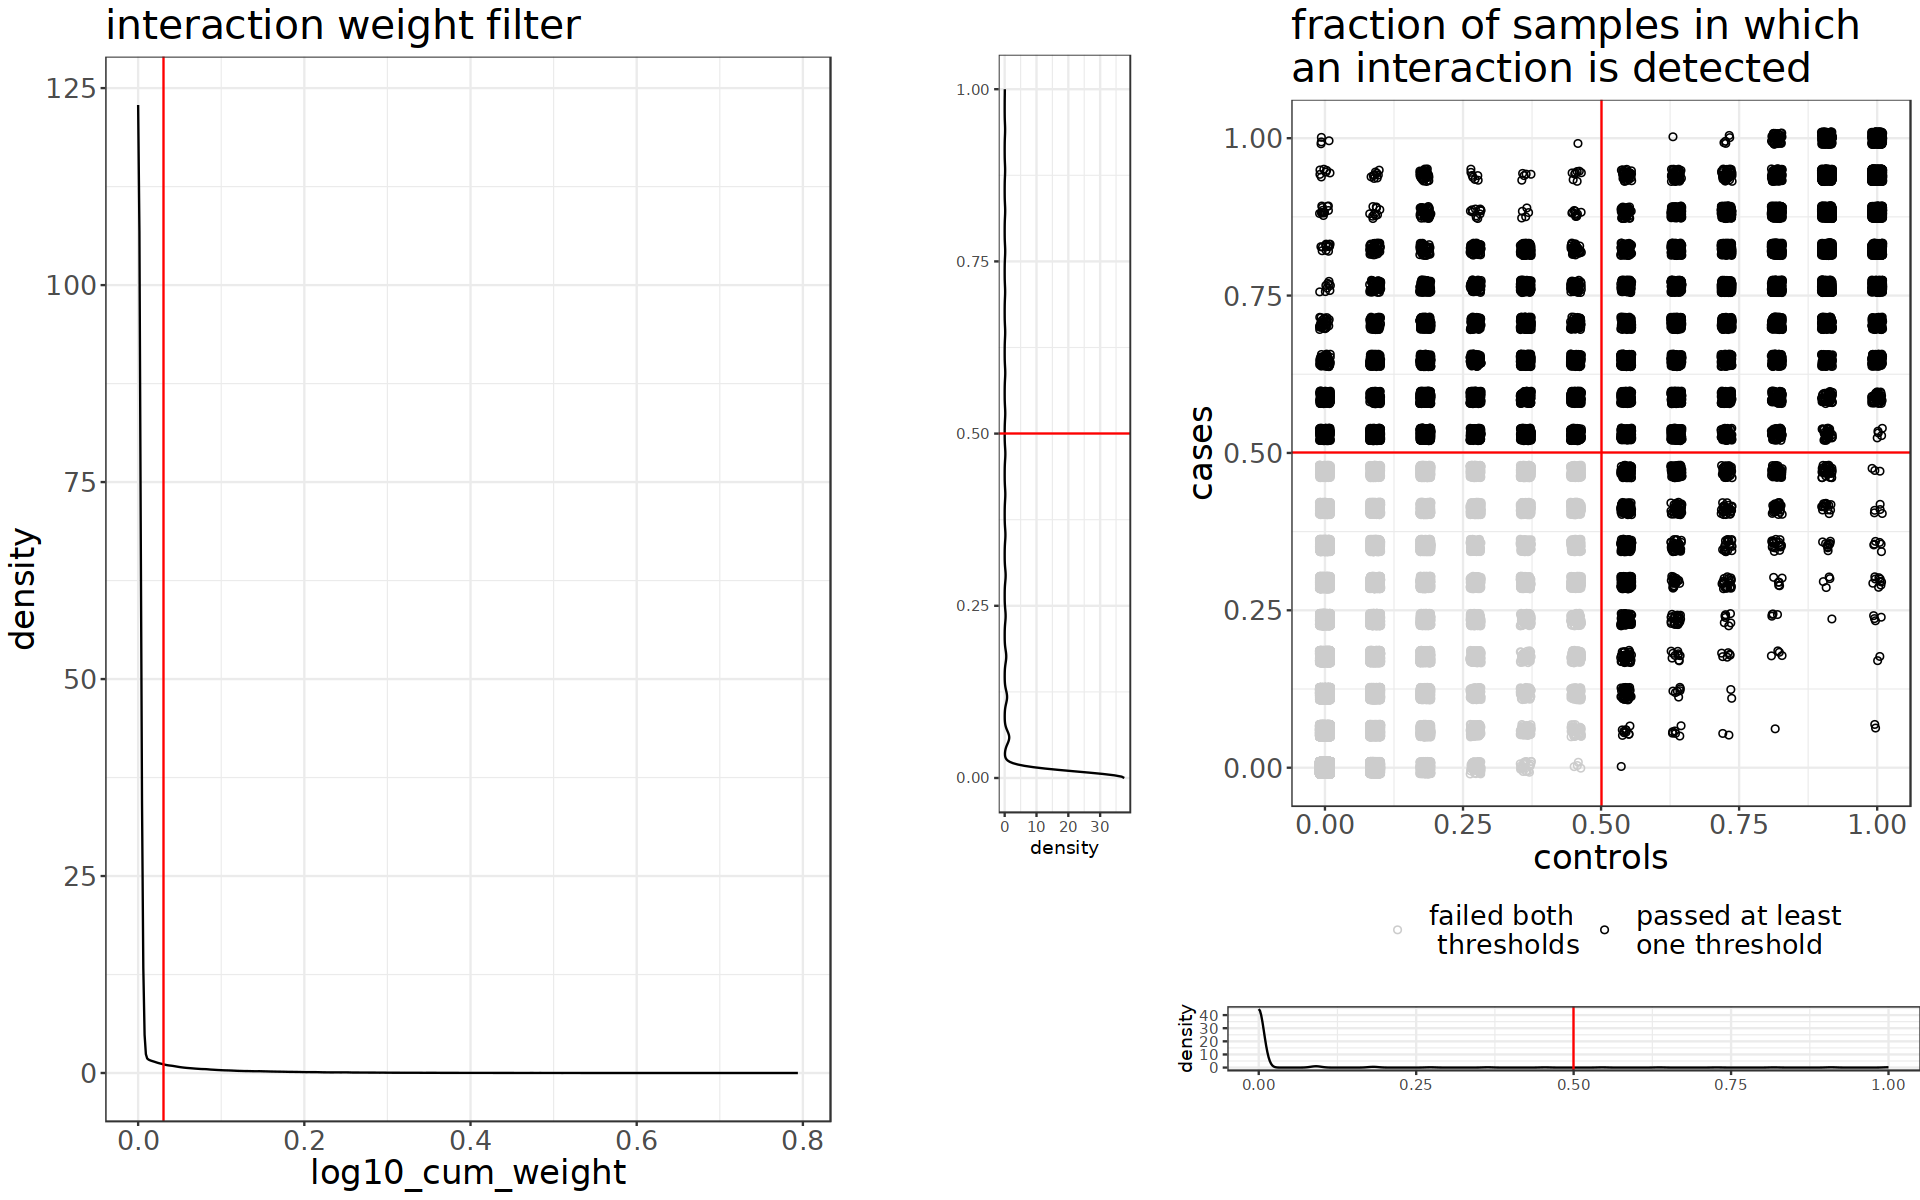

[1] "476284 out of 491959 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.03 and fraction of expressing samples > 0.5 . Also  406914  interactions didn't pass the discrepancy filter.  In total, 476284  bad quality interactions will be removed and 15675 good quality interactions will remain."


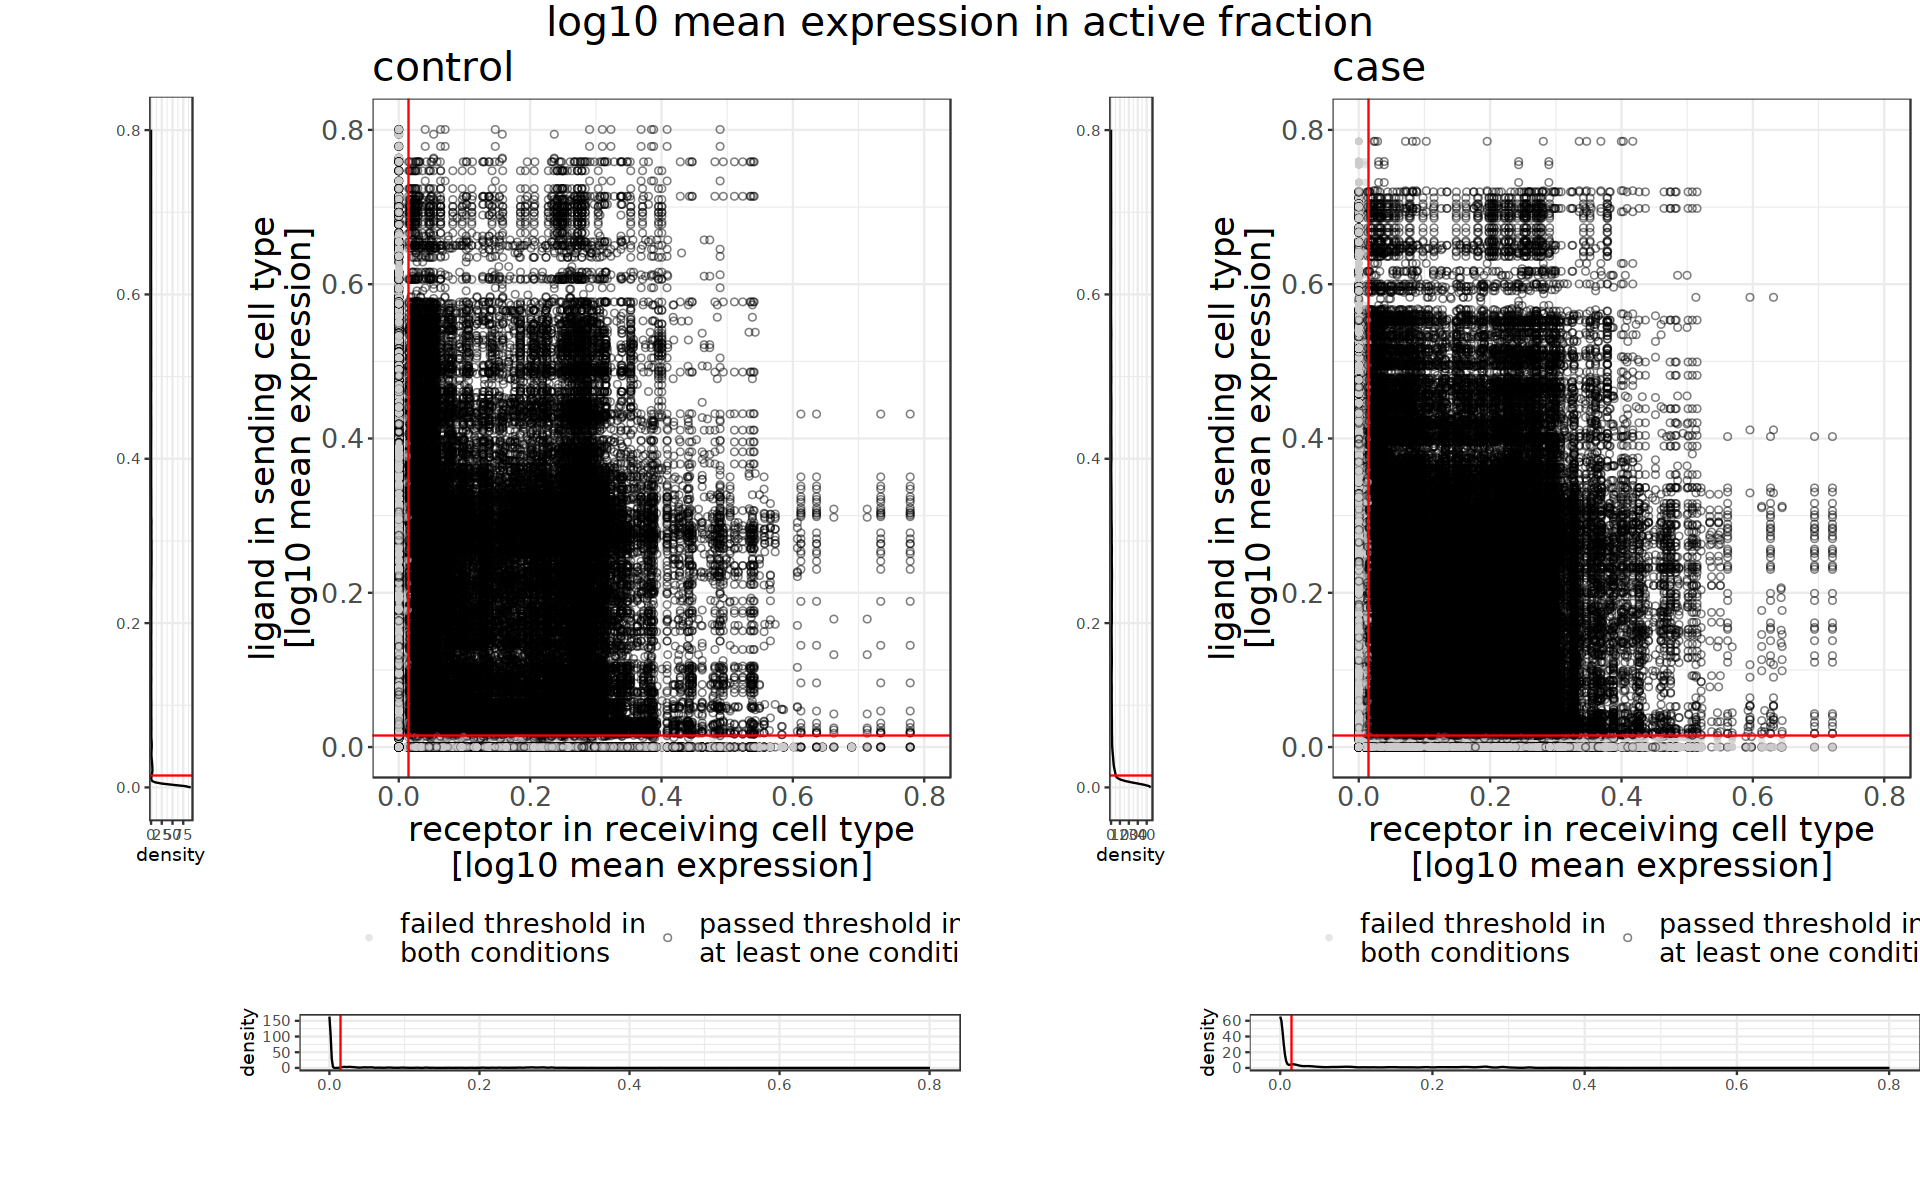

In [24]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [25]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 6
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.03
 $ threshold_frac_samples_per_condition  : num 0.5
 $ threshold_log10_meanexpr_per_condition: num 0.015
NULL
'data.frame':	491959 obs. of  28 variables:
 $ interaction_ID                            : chr  "Stem and multipotent cells:A2M_Stem and multipotent cells:LRP1" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:ADRB2" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:LDLR" "Stem and multipotent cells:ADCYAP1_Stem and multipotent cells:ADRB2" ...
 $ ligand_gene_name                          : chr  "A2M" "ACTR2" "ACTR2" "ADCYAP1" ...
 $ receptor_gene_name                        : chr  "LRP1" "ADRB2" "LDLR" "ADRB2" ...
 $ sending_cell_type                         : chr  "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cell

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [26]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [27]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. The `test_diff` function stores the results as boolean vector to the `anno_interactions` list of the interactions object.

In [28]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                          ,threshold_fdr = threshold_fdr
                          ,which_test = "t-test"
                          ,threshold_log2FC = threshold_log2FC
                          
                         )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
[1] "We have 3370 dignificantly differential interactions"
List of 8
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.03
 $ threshold_frac_samples_per_condition  : num 0.5
 $ threshold_log10_meanexpr_per_condition: num 0.015
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	491959 obs. of  33 variables:
 $ interaction_ID                            : chr  "Stem and multipotent cells:A2M_Stem and multipotent cells:LRP1" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:ADRB2" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:LDLR" "Stem and multipotent cells:ADCYAP1_Stem and multipotent cells:ADRB2" ...
 $ ligand_gene_name                          : chr  "A2M" "ACTR2" "ACTR2" "ADCYAP1" ...
 $ receptor_gene_nam

# Interplay of individual components

We defined six complnents that influence the behaviour of each interaction:
- rho_s
- phi_s_l
- p_s_l
- rho_r
- phi_r_r
- p_r_r

Each of these components can be changing independently in different directions. Based on the log2FC of each of them, we will define their direction:

**Direction of the log2FC per component**:
- *log2FC_rho_s_direction
- *log2FC_phi_s_l_direction
- *log2FC_p_s_l_direction
- *log2FC_rho_r_direction
- *log2FC_phi_r_r_direction
- *log2FC_p_r_r_direction -- can have values:
    - 0 -- if the absolute log2FC is less than the threshold_log2FC_component, i.e. unchanged
    - 1 -- if the log2FC is greater than the threshold_log2FC_component, i.e. upregulated
    - -1 -- if the log2FC is less than minus threshold_log2FC_component, i.e. downregulated

Depending on how they interplay, we will split them into groups showing different characteristics.

First, it is impornant for us to know, whether the component of only one of the two interacting partners are affected (either the sender or the receiver), or of both of them. To know this, we will calculate how many components were affected for each interacting partners:

**List of affected components per interacting partner**
- *components_affected_s* -- (sender) can have values:
- *components_affected_r* -- (receiver) can have values:
    - none
    - p
    - phi
    - rho
    - phi_p
    - rho_p
    - rho_phi
    - rho_phi_p

**Number of components affected per interacting partner**:
- *nr_comp_affected_s* -- (sender) can have values: 
    - 0, 1, 2, or 3
- *nr_comp_affected_r* -- (receiver) can have values: 
    - 0, 1, 2, or 3
- *nr_comp_affected_b* -- (both) can have values: 
    - 0, 1, 2, 3, 4, 5, or 6
    
**Which counterpart is affected**:
- *sender_or_receiver_affected* can have values:
    - none -- if nr component sender is = 0 and nr component receiver is = 0
    - sender -- if nr component sender is > 0 and nr component receiver is = 0
    - receiver -- if nr component sender is = 0 and nr component receiver is > 0
    - both -- if nr component sender is > 0 and nr component receiver is > 0
    
**Direction of the affected components per interacting partner**
- *direction_s* -- (sender) can have values:
- *direction_r* -- (receiver) can have values:
- *direction_b* -- (both) can have values:
    - none -- if zero components affected
    - up -- if >0 components affected in the same difrection (upregulated)
    - down -- if >0 components affected in the same difrection (downregulated)
    - both -- if >1 components affected in the opposite difrection
    
If several components are affected, it is important to see, if the direction of the change is the same, such that the overall change is concordant, or it is opposit, such that the the overall cahnge is disconcordant.

**Concordance of direction of affected components per interacting partner**
- *concordance_s* -- (sender) can have values:
- *concordance_r* -- (receiver) can have values:
    - undefined -- if zero or one component is affected, i.e. not enough components to talk about concordance
    - concordant -- if several components are affected in the same direction
    - disconcordant -- if several components are affected in opposit directions
- *concordance_b* -- (both) can have values:
    - undefined -- if zero or one component is affected, i.e. not enogh components to talk about concordance
    - concordant -- if several components are affected in the same direction
    - disconcordant -- if:
         - both concordance_s and concordance_r have one component changed each, but thier direction is opposit
         - both concordance_s and concordance_r have several components changed each are both concordant, but thier direction is opposit
         - either concordance_s or concordance_r is disconcordant while the other one is concordant
         - both concordance_s and concordance_r are disconcordant

**Interaction category**
 - *no_change* -- if log2FC of the interaction weight is did not pass the threshold_log2FC and none of the components is affected
    
 - *simple_decrease* -- if log2FC of the interaction weight is less than minus threshold_log2FC and only one of the components is affected and is downregulated
     
 - *simple_increase* -- if log2FC of the interaction weight is greater than the threshold_log2FC and only one of the components is affected and is upregulated
     
 - *concordant_decrease* -- if log2FC of the interaction weight is less than minus threshold_log2FC, several components are affected and all of them are downregulated
    
 - *concordant_increase* -- if log2FC of the interaction weight is greater than the threshold_log2FC, several components are affected and all of them are upregulated
    
 - *insufficient_compensation* -- if log2FC of the interaction weight is passed the threshold_log2FC in either direction and several components are affected disconcordantly
    
 - *sufficient_compensation* -- if log2FC of the interaction weight is did not pass the threshold_log2FC and several components are affected disconcordantly

In [29]:
# calculate interactions of the individual components
interactions <- interaction_classes(interactions
                   ,threshold = threshold_log2FC)
print(str(interactions$anno_interactions))

'data.frame':	491959 obs. of  52 variables:
 $ interaction_ID                            : chr  "Stem and multipotent cells:A2M_Stem and multipotent cells:LRP1" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:ADRB2" "Stem and multipotent cells:ACTR2_Stem and multipotent cells:LDLR" "Stem and multipotent cells:ADCYAP1_Stem and multipotent cells:ADRB2" ...
 $ ligand_gene_name                          : chr  "A2M" "ACTR2" "ACTR2" "ADCYAP1" ...
 $ receptor_gene_name                        : chr  "LRP1" "ADRB2" "LDLR" "ADRB2" ...
 $ sending_cell_type                         : chr  "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" ...
 $ receiving_cell_type                       : chr  "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" "Stem and multipotent cells" ...
 $ mean_e_s_l_control                        : num  0 0.97 0.97 0 0 ...
 $ mean_e_s_l_case                      

In [31]:
write.csv(interactions$weights, paste0(output_dir, "community_weights.csv"))

In [32]:
write.csv(interactions$anno_interactions, paste0(output_dir, "community_anno_interactions.csv"))

In [34]:
print("save interactions.RData")
save(interactions, file = paste0(output_dir, "interactions.RData"))

[1] "save interactions.RData"
